In [1]:
# Package imports
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import math

In [2]:
# Model Architecture Defs

#MLP
def build_model(X_,_dropout,node_sizes,net_type):
    if net_type == 'mlpnet':
        model = mlpnet(X_,_dropout,node_sizes)
    elif net_type == 'convnet':
        model = convnet(X_,_dropout,node_sizes)
    else: 
        print('unknown net architecture type')
    return model

def mlpnet(image,_dropout,node_sizes):
    l1 = mlp(image,node_sizes['input'],node_sizes['l1'],name='l1')
    l1 = tf.nn.dropout(l1,_dropout)
    l2 = mlp(l1,node_sizes['l1'],node_sizes['l2'],name='l2')
    l2 = tf.nn.dropout(l2,1)
#     l3 = mlp(l2,node_sizes['l2'],node_sizes['l3'],name='l3')
#     l3 = tf.nn.dropout(l3,1)
    l4 = mlp(l2,node_sizes['l2'],node_sizes['output'],name='l4')
    return l4

def mlp(input_,input_dim,output_dim,name="mlp"):
    with tf.variable_scope(name):
        #w = tf.get_variable('w',[input_dim,output_dim],tf.float32,tf.random_normal_initializer(mean = 0.001,stddev=0.02))
        w = tf.get_variable('w',[input_dim,output_dim],tf.float32,tf.contrib.layers.xavier_initializer())
        return tf.nn.relu(tf.matmul(input_,w))
    
    
def next_batch(s,e,inputs,labels):
    input1 = inputs[s:e]
    y = np.reshape(labels[s:e],(len(range(s,e)),2))
    return input1,y

def compute_accuracy(prediction,labels):
    correct_prediction = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
    acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))    
    return acc


In [16]:
baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/longitudinal_trajectories/exp_setup/'
#exp_setup = 'CV_Exp6_MCI_demograph_ADNI2_ADAS13_MR_bl_CS_bl_hclust_Traj.pkl'
exp_setup = 'CV_paired_long_data.pkl'

with open(baseline_dir+exp_setup, 'rb') as f:
    in_data = pickle.load(f, encoding='latin') 

### unpaired subject data
# featx = 79
# X = in_data['X'][:,18:18+featx]
# y_raw = in_data['y']

### paired long subject data
timepoint = 'L'
feat_offset = 18

X_L = np.vstack((in_data['X_L_train'][:,feat_offset:],in_data['X_L_test'][:,feat_offset:]))
X_R = np.vstack((in_data['X_R_train'][:,feat_offset:],in_data['X_R_test'][:,feat_offset:]))
pairs = np.hstack((X_L,X_R))
y_raw = np.concatenate((in_data['y_train'],in_data['y_test']))

if timepoint == 'L':
    X = X_L
elif timepoint == 'R':
    X = X_R
elif timepoint == 'L+R':
    X = pairs

    

#shuffle data
idx = np.arange(len(y_raw))
np.random.shuffle(idx)

X = X[idx,:]
y_raw = y_raw[idx]

#One-hot labels
# lb = LabelBinarizer()
# y = lb.fit_transform(y_raw)
y = np.vstack((np.array(y_raw==0).astype(int),np.array(y_raw==1).astype(int))).T
#print(y_raw)
print(y.shape)

n = X.shape[0]
d = X.shape[1]

print(n,d)

(936, 2)
936 78


In [17]:
n_train = int(0.8*n)
n_val = int(0.1*n)

X_train = X[:n_train]
X_val   = X[n_train:n_train+n_val]
X_test  = X[n_train+n_val:]

y_train = y[:n_train]
y_val   = y[n_train:n_train+n_val]
y_test  = y[n_train+n_val:]

print(len(y_train),len(y_val),len(y_test))
print(np.sum(y_raw[:n_train]==1)/len(y_train),np.sum(y_raw[n_train:n_train+n_val]==1)/len(y_val),np.sum(y_raw[n_train+n_val:]==1)/len(y_test))
print(np.sum(y_raw[:n_train]==0)/len(y_train),np.sum(y_raw[n_train:n_train+n_val]==0)/len(y_val),np.sum(y_raw[n_train+n_val:]==0)/len(y_test))

748 93 95
0.516042780749 0.494623655914 0.568421052632
0.483957219251 0.505376344086 0.431578947368


In [24]:
batch_size = 50
num_epochs = 100
n_folds = 1
lr = 0.00001
keep_p = 1

train_loss = []
train_acc = []
valid_acc = []
test_acc = []

for fid in range(1,n_folds+1,1):        
    node_sizes = {'input':d,'l1':50,'l2':50,'l3':0,'output':2,'kernel_dim':5,'max_pool_redux_factor':16}
    with tf.Graph().as_default():    
        data = tf.placeholder(tf.float32,shape=([None,node_sizes['input']]),name='input_data')        
        labels = tf.placeholder(tf.float32,shape=([None,2]),name='gt')                
        dropout_f = tf.placeholder("float")

        with tf.variable_scope("adninet") as scope:
            model1= build_model(data,dropout_f,node_sizes,'mlpnet')            
            
        
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(model1,labels))         
        acc = compute_accuracy(model1,labels)
        
#         t_vars = tf.trainable_variables()
#         d_vars  = [var for var in t_vars if 'l' in var.name]
#         batch = tf.Variable(0)
        optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(loss)
        #optimizer = tf.train.RMSPropOptimizer(0.0001,momentum=0.9,epsilon=1e-6).minimize(loss)

        # Launch the graph
        with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
            #sess.run(init)
            tf.initialize_all_variables().run()
            # Training cycle
            for epoch in range(num_epochs):
                avg_loss = 0.
                avg_acc = 0.
                total_batch = int(X_train.shape[0]/batch_size)
                start_time = time.time()
                # Loop over all batches
                for i in range(total_batch):
                    s  = i * batch_size
                    e = (i+1) *batch_size
                    
                    # Fit training using batch data
                    tr_X,tr_y = next_batch(s,e,X_train,y_train)  
                    #print(input1.shape, y.shape)
                                
                    _,tr_loss,tr_acc=sess.run([optimizer,loss,acc], 
                                                  feed_dict={data:tr_X,labels:tr_y,dropout_f:keep_p})
                    
                    predict=model1.eval(feed_dict={data:tr_X,dropout_f:1.0})                    
                    tr_acc = compute_accuracy(predict,tr_y).eval()                
                                        
                    #print(tr_acc.eval())
#                     if math.isnan(tr_acc) and epoch != 0:
#                         print('tr_acc %0.2f' % tr_acc)
#                         pdb.set_trace()

                    avg_loss += tr_loss
                    avg_acc +=tr_acc*100
                                        
                #print('epoch %d loss %0.2f' %(epoch,avg_loss/total_batch))
                duration = time.time() - start_time
                #print('epoch %d  time: %f loss %0.5f acc %0.2f' %(epoch,duration,avg_loss/(total_batch),avg_acc/total_batch))
                train_loss.append(avg_loss/(total_batch))
                train_acc.append(avg_acc/total_batch)
                
                #Check performance on validation set                                                                                
                predict=model1.eval(feed_dict={data:X_val,dropout_f:1.0})                
                va_acc = compute_accuracy(predict,y_val).eval()*100.0
                valid_acc.append(va_acc)
                
                # Test model                                    
                predict= model1.eval(feed_dict={data:X_test,dropout_f:1.0})                
                te_acc = compute_accuracy(predict,y_test).eval()*100
                test_acc.append(te_acc)
                
                
                if epoch%10 == 0:
                    print('Accuracy validation set %0.2f' % ((va_acc)))

            #Accuracy of the entire training set at the end of training            
            predict= model1.eval(feed_dict={data:X_train, dropout_f:1.0})                
            tr_acc = compute_accuracy(predict,y_train).eval()*100
            print('Accuracy training set %0.2f' % (tr_acc))
            print('Accuracy validation set %0.2f' % (va_acc))


            # Test model                                    
            predict= model1.eval(feed_dict={data:X_test,dropout_f:1.0})                
            te_acc = compute_accuracy(predict,y_test)
            #test_acc.append(te_acc)
            print('Accuracy test set %0.2f' % (100 * te_acc.eval()))
        

Accuracy validation set 47.31
Accuracy validation set 45.16
Accuracy validation set 49.46
Accuracy validation set 51.61
Accuracy validation set 51.61
Accuracy validation set 51.61
Accuracy validation set 51.61
Accuracy validation set 50.54
Accuracy validation set 50.54
Accuracy validation set 49.46
Accuracy training set 56.68
Accuracy validation set 50.54
Accuracy test set 65.26


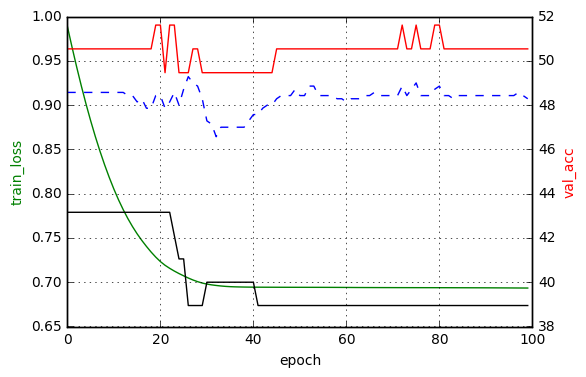

In [22]:
# Plot Acc and Loss
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(train_loss, 'g-')
ax2.plot(train_acc, 'b--')
ax2.plot(valid_acc, 'r-')
ax2.plot(test_acc, 'k-')


ax1.set_xlabel('epoch')
ax1.set_ylabel('train_loss', color='g')
ax2.set_ylabel('val_acc', color='r')
ax1.grid()

In [202]:
test_acc


[<tf.Tensor 'Mean_5:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_9:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_13:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_17:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_21:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_25:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_29:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_33:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_37:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_41:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_45:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_49:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_53:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_57:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_61:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_65:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_69:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_73:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_77:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_81:0' shape=() dtype=float32>,
 <tf.Tensor 'Mean_85:0